THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Inspired by <https://medium.com/@sahoo.puspanjali58/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it-9daee61eab2b>

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist

2022-02-03 13:55:55.241244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-03 13:55:55.241291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Select which configurations to run

In [2]:
epochs = False
dense_layer_size = False
dense_layer_count = False
compare_noise = True

## Load the MNIST dataset

In [3]:
(X_train_orig, _), (X_test, _) = mnist.load_data()
# verify size
np.concatenate((X_train_orig, X_test)).shape

(70000, 28, 28)

## Function to add noise to an image array, taken from <https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv>

In [4]:
def add_noise(images, amount=0.1):
    corrupted = []
    for image in images:
        s_vs_p = 0.5
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, j - 1, int(num_salt))
                  for j in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, j - 1, int(num_pepper))
                  for j in image.shape]
        out[coords] = 0
        corrupted.append(tuple(out))
    return np.array(corrupted)

## Normalize RGB codes and create corrupted data

In [5]:
max_value = float(X_train_orig.max())
X_Train = X_train_orig.astype(np.float32) / max_value
X_Test = X_test.astype(np.float32) / max_value

#Train and validation split
X_train, X_valid = X_Train, X_Test
X_corrupted = add_noise(X_train, amount=0.4)
# needed for displaying later
X_valid_but_noisy = add_noise(X_valid, amount=0.4)
X_train.shape, X_valid.shape, X_corrupted.shape

/home/delta/PycharmProjects/SeminarNI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/delta/PycharmProjects/SeminarNI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


((60000, 28, 28), (10000, 28, 28), (60000, 28, 28))

## Plot the given image

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Create a plot to show 10 original and reconstructed images beneath each other.

### When noise is True, the corrupted image will be displayed as well

In [7]:
#Displays the original images and their reconstructions
def show_reconstructions(model, images=X_valid, n_images=10, noise=False):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    cols = 2
    if noise:
        cols = 3
    for image_index in range(n_images):
        # add original image to plot
        plt.subplot(cols, n_images, 1 + image_index)
        plot_image(images[image_index])
        # add noisy image to plot, if needed
        if noise:
            plt.subplot(cols, n_images, 1 + n_images + image_index)
            plot_image(X_valid_but_noisy[image_index])
        # add reconstructed  image to plot
        plt.subplot(cols, n_images, 1 + (cols - 1) * n_images + image_index)
        plot_image(reconstructions[image_index])

## Train the autoencoder on a different number of epochs (runs)

In [8]:
if epochs:
    runs = [1, 5, 10, 20, 50]

    for i in runs:
        #Stacked Autoencoder with functional model
        #encoder
        inputs = keras.Input(shape=(28, 28))
        layer_flatten = keras.layers.Flatten()(inputs)
        layer1 = keras.layers.Dense(392, activation="selu")(layer_flatten)
        layer2 = keras.layers.Dense(28 * 28, activation="sigmoid")(layer1)
        outputs = keras.layers.Reshape([28, 28])(layer2)
        autoencoder = keras.models.Model(inputs, outputs)
        autoencoder.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.1))
        autoencoder.summary()
        callbacks = keras.callbacks.TensorBoard(
            log_dir="logs/epochs/number_of_epochs_" + str(i),
            histogram_freq=0,
            write_graph=True,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,
        )

        h_stack = autoencoder.fit(X_train, X_train, epochs=i, validation_data=[X_valid, X_valid], callbacks=[callbacks])
        show_reconstructions(autoencoder)

## Train the autoencoder on different dense layer sizes. Here only one dense layer is used.

In [9]:
if dense_layer_size:
    layer_size = [392, 196, 98]

    for i in layer_size:
        #encoder
        inputs = keras.Input(shape=(28, 28))
        lr_flatten = keras.layers.Flatten()(inputs)
        layer1 = keras.layers.Dense(i, activation="selu")(lr_flatten)
        layer2 = keras.layers.Dense(28 * 28, activation="sigmoid")(layer1)
        outputs = keras.layers.Reshape([28, 28])(layer2)
        autoencoder = keras.models.Model(inputs, outputs)
        autoencoder.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.1))
        autoencoder.summary()
        callbacks = keras.callbacks.TensorBoard(
            log_dir="logs/layer_size/layer_size_" + str(i),
            histogram_freq=0,
            write_graph=True,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,
        )

        h_stack = autoencoder.fit(X_train, X_train, epochs=50, validation_data=[X_valid, X_valid], callbacks=[callbacks])
        show_reconstructions(autoencoder)

## Train the autoencoder on a combination of different dense layer sizes and count.

|  number of dense layers |         dense layer size (ordered)         |
|------------------------:|:------------------------------------------:|
|                       1 |                    392                     |
|                       3 |                392-196-392                 |
|                       3 |                 392-98-392                 |
|                       3 |                 196-98-196                 |
|                       5 |             392-196-98-196-392             |

In [10]:
if dense_layer_count:
    for i in range(5):
        #Stacked Autoencoder with functional model
        #encoder
        inputs = keras.Input(shape=(28, 28))
        lr_flatten = keras.layers.Flatten()(inputs)
        if i == 0:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer1)
        elif i == 1:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(392, activation="selu")(layer2)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer3)
        elif i == 2:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(98, activation="selu")(layer1)
            layer3 = keras.layers.Dense(392, activation="selu")(layer2)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer3)
        elif i == 3:
            layer1 = keras.layers.Dense(196, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(98, activation="selu")(layer1)
            layer3 = keras.layers.Dense(196, activation="selu")(layer2)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer3)
        else:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(98, activation="selu")(layer2)
            layer4 = keras.layers.Dense(196, activation="selu")(layer3)
            layer5 = keras.layers.Dense(392, activation="selu")(layer4)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer5)


        outputs = keras.layers.Reshape([28, 28])(final_layer)
        autoencoder = keras.models.Model(inputs, outputs)
        autoencoder.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.1))
        autoencoder.summary()
        callback = keras.callbacks.TensorBoard(
            log_dir="logs/layer_count/run_" + str(i),
            histogram_freq=0,
            write_graph=True,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,
        )

        h_stack = autoencoder.fit(X_train, X_train, epochs=50, validation_data=[X_valid, X_valid], callbacks=[callback])
        show_reconstructions(autoencoder)

## Train the autoencoder on a combination of different dense layer sizes and count. Additionally, every run is repeated on the corrupted dataset.

|  number of dense layers |         dense layer size (ordered)         | noise |
|------------------------:|:------------------------------------------:|-------|
|                       1 |                    392                     | none  |
|                       3 |                392-196-392                 | none  |
|                       5 |             392-196-98-196-392             | none  |
|                       1 |                    392                     | yes   |
|                       3 |                392-196-392                 | yes   |
|                       5 |             392-196-98-196-392             | yes   |

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_40 (Dense)            (None, 392)               307720    
                                                                 
 dense_41 (Dense)            (None, 784)               308112    
                                                                 
 reshape_11 (Reshape)        (None, 28, 28)            0         
                                                                 
Total params: 615,832
Trainable params: 615,832
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1875/1875 [==============================

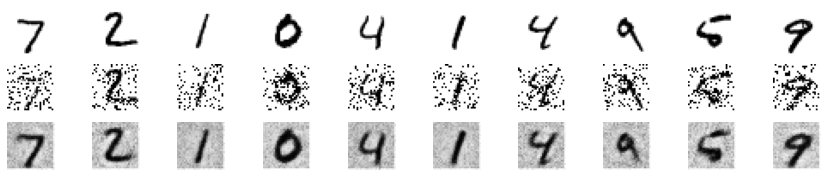

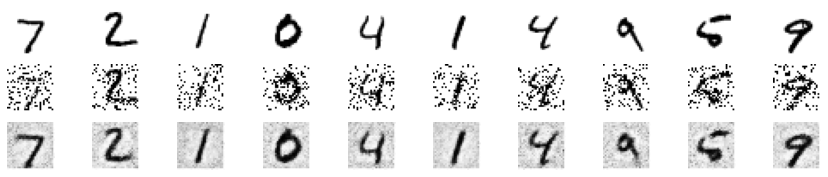

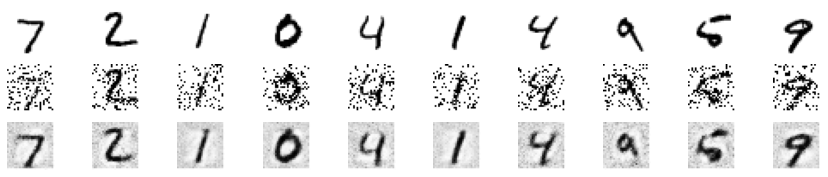

In [14]:
if compare_noise:
    for i in range(3):
        inputs = keras.Input(shape=(28, 28))
        lr_flatten = keras.layers.Flatten()(inputs)
        if i == 0:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer1)
        elif i == 1:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(392, activation="selu")(layer2)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer3)
        else:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(98, activation="selu")(layer2)
            layer4 = keras.layers.Dense(196, activation="selu")(layer3)
            layer5 = keras.layers.Dense(392, activation="selu")(layer4)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer5)


        outputs = keras.layers.Reshape([28, 28])(final_layer)
        autoencoder = keras.models.Model(inputs, outputs)
        autoencoder.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.1))
        autoencoder.summary()
        callback = keras.callbacks.TensorBoard(
            log_dir="logs/compare_noise/no_noise_layers_" + str(i * 2 + 1),
            histogram_freq=0,
            write_graph=True,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,
        )

        h_stack = autoencoder.fit(X_train, X_train, epochs=50, validation_data=[X_valid, X_valid], callbacks=[callback])
        show_reconstructions(autoencoder)

    for i in range(3):
        inputs = keras.Input(shape=(28, 28))
        lr_flatten = keras.layers.Flatten()(inputs)
        if i == 0:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer1)
        elif i == 1:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(392, activation="selu")(layer2)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer3)
        else:
            layer1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
            layer2 = keras.layers.Dense(196, activation="selu")(layer1)
            layer3 = keras.layers.Dense(98, activation="selu")(layer2)
            layer4 = keras.layers.Dense(196, activation="selu")(layer3)
            layer5 = keras.layers.Dense(392, activation="selu")(layer4)
            final_layer = keras.layers.Dense(28 * 28, activation="sigmoid")(layer5)


        outputs = keras.layers.Reshape([28, 28])(final_layer)
        autoencoder = keras.models.Model(inputs, outputs)
        autoencoder.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.1))
        autoencoder.summary()
        callback = keras.callbacks.TensorBoard(
            log_dir="logs/compare_noise/with_noise_layers_" + str(i * 2 + 1),
            histogram_freq=0,
            write_graph=True,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=0,
            embeddings_metadata=None,
        )

        h_stack = autoencoder.fit(X_corrupted, X_corrupted, epochs=50, validation_data=[X_valid, X_valid], callbacks=[callback])
        show_reconstructions(autoencoder, noise=True)